<a href="https://colab.research.google.com/github/YoonhoNam/hufsclass/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3. Concise Implementation of Linear Regression with csv data

- 이 실습에서는 csv파일에서 데이터를 가져와 linear regression을 수행해 보겠습니다. 
- csv파일은 covid-19 data를 활용해 보겠습니다. latitude와 longitude를 features로 했을 때 오늘 누적확진자수를 예측하는 모델을 linear model로 표현할 수 있을까요?

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data_file = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(data_file)
print(data.shape)
data[140:145]

(259, 78)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
140,NaN,Jordan,31.2400,36.5100,0,0,0,0,0,0,...,212,235,246,259,268,274,278,299,310,323
141,NaN,Kazakhstan,48.0196,66.9237,0,0,0,0,0,0,...,111,150,228,284,302,343,380,435,464,531
142,NaN,Kenya,-0.0236,37.9062,0,0,0,0,0,0,...,31,31,38,42,50,59,81,110,122,126
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,9241,9332,9478,9583,9661,9786,9887,9976,10062,10156
144,NaN,Kuwait,29.5000,47.7500,0,0,0,0,0,0,...,208,225,235,255,266,289,317,342,417,479


- 우선 데이터를 살펴보도록 하겠습니다. first feature를 Lat(index:2), second feature를 Long(index:3)으로 하여 가장 최근 날짜의 누적확진자수를 plot해보면 linearity를 관찰하기는 쉽지 않아 보입니다.

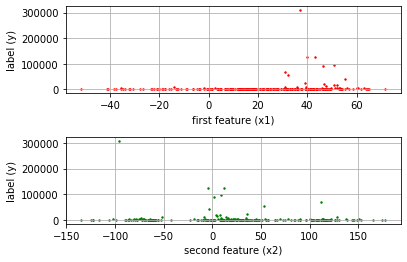

In [3]:
fig,((ax1, ax2))=plt.subplots(2,gridspec_kw={'hspace':0.5})
ax1.scatter(data.iloc[:,2], data.iloc[:,-1],s=2,color='r')
ax1.set_xlabel('first feature (x1)')
ax1.set_ylabel('label (y)')
ax1.grid('both')
ax2.scatter(data.iloc[:,3], data.iloc[:,-1],s=2,color='g')
ax2.set_xlabel('second feature (x2)')
ax2.set_ylabel('label (y)')
ax2.grid('both')

- 특정 국가들이 너무 큰 숫자들을 가지기 때문에 관찰이 어렵습니다. 확진자수에 log를 취하여 관찰해봅시다. 첫 번째 feature인 latitude에서 경향이 약간 보이는 것 같기는 합니다. 아무래도 북반구에 위치한 국가들이 확진자수가 많기 때문인 것 같습니다.

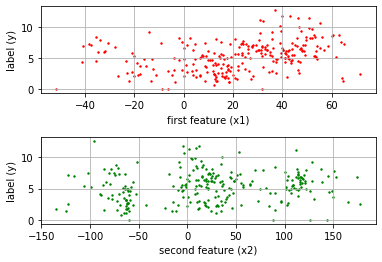

In [4]:
import numpy as np
fig,((ax1, ax2))=plt.subplots(2,gridspec_kw={'hspace':0.5})
ax1.scatter(data.iloc[:,2], np.log(data.iloc[:,-1]),s=2,color='r')
ax1.set_xlabel('first feature (x1)')
ax1.set_ylabel('label (y)')
ax1.grid('both')
ax2.scatter(data.iloc[:,3], np.log(data.iloc[:,-1]),s=2,color='g')
ax2.set_xlabel('second feature (x2)')
ax2.set_ylabel('label (y)')
ax2.grid('both')

- 위도와 경도를 feature로 하고, 가장 최근 날짜의 누적확진자수에 log를 취한 결과를 label로 하여 테스트를 해봅시다.
- 우리의 csv파일은 총 259개의 example을 포함하고 있습니다. 임의로 230개의 example를 train set으로 하고, 나머지를 test set으로 남겨두겠습니다.

In [6]:
train_N = 230
features, labels, country = data.iloc[:train_N,[2,3]], data.iloc[:train_N,-1], data.iloc[:train_N,[0,1]]
features_test, labels_test, country_test = data.iloc[train_N:,[2,3]], data.iloc[train_N:,-1], data.iloc[train_N:,[0,1]]

features = (torch.tensor(features.values).float())
labels = torch.log(torch.tensor(labels.values).reshape(-1,1).float())
features_test = (torch.tensor(features_test.values).float())
labels_test = torch.log(torch.tensor(labels_test.values).reshape(-1,1).float())
n=0
print(features.shape)
print(labels.reshape(-1,1).shape)

torch.Size([230, 2])
torch.Size([230, 1])


- 의도한대로 데이터가 pytorch tensor로 변환이 되었는지 plot을 하여 확인해 봅니다.

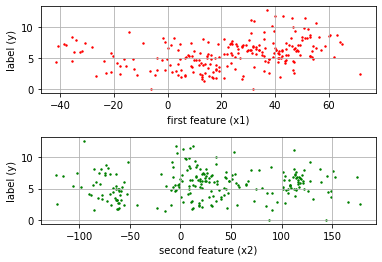

In [7]:
fig,((ax1, ax2))=plt.subplots(2,gridspec_kw={'hspace':0.5})
ax1.scatter(features[:,0].numpy(), labels.numpy(),s=2,color='r')
ax1.set_xlabel('first feature (x1)')
ax1.set_ylabel('label (y)')
ax1.grid('both')
ax2.scatter(features[:,1].numpy(), labels.numpy(),s=2,color='g')
ax2.set_xlabel('second feature (x2)')
ax2.set_ylabel('label (y)')
ax2.grid('both')

- linear model를 훈련시켜보겠습니다. 결과를 보면서 hyper parameter들을 정해주어야 합니다. 
- learning rate는 대개는 다소 큰 값에서 시작해서 조금씩 줄여 나가면서 결과를 관찰합니다.

In [9]:
# setting hyper-parameters
batch_size = 10
learning_rate = 0.0001
num_epochs = 1500

# defining data_iter, linreg. model, loss, sgd
data_iter = DataLoader(dataset=TensorDataset(features,labels),batch_size=batch_size,shuffle=True) # data_iter
linreg = nn.Linear(2,1,bias=True) # model
linreg.weight.data=torch.zeros(size=(1,2)).normal_(std=0.01) # parameter initialization (w)
linreg.bias.data=torch.zeros(size=(1,)) # parameter initialization (b)
loss = torch.nn.MSELoss() # loss
alg = torch.optim.SGD(linreg.parameters(),lr=learning_rate) # sgd

# training the model
for epoch in range(num_epochs):
  for X,y in data_iter:
    l=loss(linreg(X),y)
    alg.zero_grad()
    l.backward()
    alg.step()
  if epoch%100==0:
    l_epoch = loss(linreg(features),labels)
    print('epoch %d, loss: %f' % (epoch, l_epoch))

epoch 0, loss: 16.329967
epoch 100, loss: 14.272455
epoch 200, loss: 9.550521
epoch 300, loss: 7.809585
epoch 400, loss: 6.728880
epoch 500, loss: 6.181114
epoch 600, loss: 5.610019
epoch 700, loss: 5.454592
epoch 800, loss: 5.815940
epoch 900, loss: 5.306874
epoch 1000, loss: 4.992438
epoch 1100, loss: 7.296197
epoch 1200, loss: 6.094347
epoch 1300, loss: 5.193887
epoch 1400, loss: 4.799847


- 훈련이 끝난 모델에 test set의 데이터를 넣어 확인을 결과를 보겠습니다.
- 우리는 이미 선형적인 관계가 분명하지 않은 것을 이미 데이터를 plot하여 확인을 하였기 때문에 만족할만한 결과를 얻기는 쉽지 않을 것입니다. 

In [10]:
for n in range(len(country_test)):
  print('국가명: ',country_test.iloc[n,1])
  print('위도:',features_test[n,0].numpy(),'경도:',features_test[n,1].numpy())
  print('실제 누적확진자수: ',np.exp(labels_test[n].numpy()))
  print('예측한 누적확진자수: ',np.exp(linreg(features_test[n]).detach().numpy()),'\n\n')

국가명:  Zimbabwe
위도: -20.0 경도: 30.0
실제 누적확진자수:  [9.]
예측한 누적확진자수:  [102.51666] 


국가명:  Canada
위도: 0.0 경도: 0.0
실제 누적확진자수:  [0.]
예측한 누적확진자수:  [109.67267] 


국가명:  Dominica
위도: 15.415 경도: -61.371
실제 누적확진자수:  [14.]
예측한 누적확진자수:  [59.005913] 


국가명:  Grenada
위도: 12.1165 경도: -61.679
실제 누적확진자수:  [12.]
예측한 누적확진자수:  [53.20689] 


국가명:  Mozambique
위도: -18.665695 경도: 35.529564
실제 누적확진자수:  [10.000001]
예측한 누적확진자수:  [117.5444] 


국가명:  Syria
위도: 34.802074 경도: 38.996815
실제 누적확진자수:  [16.]
예측한 누적확진자수:  [612.11536] 


국가명:  Timor-Leste
위도: -8.874217 경도: 125.72754
실제 누적확진자수:  [1.]
예측한 누적확진자수:  [766.8191] 


국가명:  Belize
위도: 13.1939 경도: -59.5432
실제 누적확진자수:  [4.]
예측한 누적확진자수:  [57.038578] 


국가명:  Canada
위도: 0.0 경도: 0.0
실제 누적확진자수:  [0.]
예측한 누적확진자수:  [109.67267] 


국가명:  Laos
위도: 19.85627 경도: 102.4955
실제 누적확진자수:  [10.000001]
예측한 누적확진자수:  [1197.6342] 


국가명:  Libya
위도: 26.3351 경도: 17.22833
실제 누적확진자수:  [18.]
예측한 누적확진자수:  [324.6923] 


국가명:  West Bank and Gaza
위도: 31.9522 경도: 35.2332
실제 누적확진자수:  [216.99994]
예측한 누적